# YOLOv2検討ノート

In [18]:
from __future__ import unicode_literals
from __future__ import print_function
import sys
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import json

import chainer
import chainer.functions as F
import chainer.links as L

%reload_ext autoreload
%autoreload 2

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
sys.version

'2.7.13 |Anaconda 4.3.0 (x86_64)| (default, Dec 20 2016, 23:05:08) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

In [3]:
chainer.__version__

'1.22.0'

In [4]:
cv2.__version__

'3.1.0'

In [5]:
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('__file__')), '..', 'cmd', 'yolo', 'lib'))
from config import *
from yolo_v2 import *
from bounding_box import *
from image_process import *

sys.path.append(os.path.join(os.path.dirname(os.path.abspath('__file__')), '..', 'cmd', 'yolo', 'detector'))
from yolo_trainer import *

## データセットの読み出し

In [6]:
with open(os.path.join('..', 'cache', 'SingleAug', 'single_aug_catalog.json'), 'r') as fp:
    catalog = json.load(fp)
    
train_dataset = filter(lambda item: item['bounding_boxes'] != [], catalog['dataset'])
len(train_dataset)

20000

In [137]:
INPUT_SIZE / 640., INPUT_SIZE / 480.

(0.35, 0.4666666666666667)

In [130]:
real_truth_boxes = np.asarray([[dict_to_box(box) for box in item['bounding_boxes']]
                                for item in train_dataset])
real_truth_boxes[0:10]

array([[<Box x:280.0 y:135.0 w:283.0 h:310.0 c:17 o:1.0>],
       [<Box x:19.0 y:0.0 w:592.0 h:416.0 c:11 o:1.0>],
       [<Box x:269.0 y:207.0 w:207.0 h:211.0 c:5 o:1.0>],
       [<Box x:404.0 y:87.0 w:97.0 h:353.0 c:15 o:1.0>],
       [<Box x:53.0 y:127.0 w:250.0 h:291.0 c:17 o:1.0>],
       [<Box x:270.0 y:115.0 w:191.0 h:314.0 c:12 o:1.0>],
       [<Box x:36.0 y:0.0 w:429.0 h:425.0 c:4 o:1.0>],
       [<Box x:9.0 y:0.0 w:452.0 h:429.0 c:4 o:1.0>],
       [<Box x:178.0 y:0.0 w:160.0 h:432.0 c:13 o:1.0>],
       [<Box x:102.0 y:171.0 w:512.0 h:259.0 c:7 o:1.0>]], dtype=object)

In [131]:
yolo_truth_boxes = [[real_to_yolo_coord(box, 640, 480) for box in boxes]
                    for boxes in real_truth_boxes]
yolo_truth_boxes[0:10]

[[<Box x:98.0 y:63.0 w:99.05 h:144.666666667 c:17 o:1.0>],
 [<Box x:6.65 y:0.0 w:207.2 h:194.133333333 c:11 o:1.0>],
 [<Box x:94.15 y:96.6 w:72.45 h:98.4666666667 c:5 o:1.0>],
 [<Box x:141.4 y:40.6 w:33.95 h:164.733333333 c:15 o:1.0>],
 [<Box x:18.55 y:59.2666666667 w:87.5 h:135.8 c:17 o:1.0>],
 [<Box x:94.5 y:53.6666666667 w:66.85 h:146.533333333 c:12 o:1.0>],
 [<Box x:12.6 y:0.0 w:150.15 h:198.333333333 c:4 o:1.0>],
 [<Box x:3.15 y:0.0 w:158.2 h:200.2 c:4 o:1.0>],
 [<Box x:62.3 y:0.0 w:56.0 h:201.6 c:13 o:1.0>],
 [<Box x:35.7 y:79.8 w:179.2 h:120.866666667 c:7 o:1.0>]]

In [142]:
98.0 / 32

3.0625

In [129]:
ts = [[yolo_to_grid_coord(box) for box in boxes] for boxes in yolo_truth_boxes]
ts[0:10]

[[<Box x:3.0625 y:1.96875 w:3.0953125 h:4.52083333333 c:17 o:1.0>],
 [<Box x:0.2078125 y:0.0 w:6.475 h:6.06666666667 c:11 o:1.0>],
 [<Box x:2.9421875 y:3.01875 w:2.2640625 h:3.07708333333 c:5 o:1.0>],
 [<Box x:4.41875 y:1.26875 w:1.0609375 h:5.14791666667 c:15 o:1.0>],
 [<Box x:0.5796875 y:1.85208333333 w:2.734375 h:4.24375 c:17 o:1.0>],
 [<Box x:2.953125 y:1.67708333333 w:2.0890625 h:4.57916666667 c:12 o:1.0>],
 [<Box x:0.39375 y:0.0 w:4.6921875 h:6.19791666667 c:4 o:1.0>],
 [<Box x:0.0984375 y:0.0 w:4.94375 h:6.25625 c:4 o:1.0>],
 [<Box x:1.946875 y:0.0 w:1.75 h:6.3 c:13 o:1.0>],
 [<Box x:1.115625 y:2.49375 w:5.6 h:3.77708333333 c:7 o:1.0>]]

In [144]:
ts[0][0].center

<Point x:4.61015625 y:4.22916666667>

In [11]:
math.modf(b.center.x)

(0.6101562500000002, 4.0)

## 推論を実行

In [36]:
model = YoloDetector()

model_file = os.path.join('..', 'cmd', 'yolo', 'detector', 'detector_iter00100.model')
if os.path.exists(model_file):
    print('load model: %s' % model_file)
    chainer.serializers.load_npz(model_file, model)

load model: ../cmd/yolo/detector/detector_iter00100.model


In [13]:
ix = np.random.randint(0,19999)
print(ix)
dataset = train_dataset[ix:ix+10]

14078


In [14]:
images = [Image(item['color_image_path'], INPUT_SIZE, INPUT_SIZE).image for item in dataset]

batch_size = len(images)
batch_size, images[0].shape

(10, (224, 224, 3))

In [15]:
xs = chainer.Variable(np.asarray(images).transpose(0,3,1,2).astype(np.float32) / 255.)

In [37]:
h = model.forward(xs)

In [38]:
px, py, pw, ph, pconf, pprob = F.split_axis(h, indices_or_sections=(1,2,3,4,5), axis=2)
px = F.sigmoid(px)
py = F.sigmoid(py)
pconf = F.sigmoid(pconf)
pprob = F.sigmoid(pprob)

px.shape, py.shape, pw.shape, ph.shape, pconf.shape, pprob.shape

((10, 155, 1, 7),
 (10, 155, 1, 7),
 (10, 155, 1, 7),
 (10, 155, 1, 7),
 (10, 155, 1, 7),
 (10, 155, 2, 7))

In [146]:
7 - float(1.0)

6.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116039290>]], dtype=object)

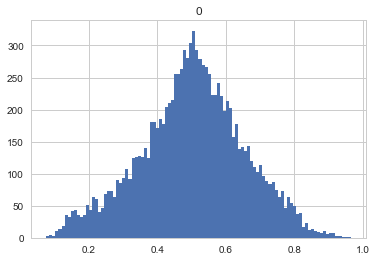

In [74]:
df = pd.DataFrame(px.data.ravel())
df.describe()

df.hist(bins=100)

In [39]:
pw.data

array([[[[-0.15054862, -0.12858479, -0.25137579, ...,  0.16338889,
           0.21674825,  0.22479589]],

        [[ 0.83623922,  0.6110841 ,  0.39066556, ..., -0.07955901,
          -0.25488299, -0.22489552]],

        [[-0.04618618,  0.21556096,  0.05491767, ..., -0.31936574,
          -0.54518181, -0.19545671]],

        ..., 
        [[-0.06010967, -0.01834818,  0.33373502, ...,  0.22413914,
          -0.1017428 , -0.17785785]],

        [[-0.19888549,  0.59345829, -0.2411927 , ..., -0.28254509,
          -0.24750769, -0.55700296]],

        [[ 0.25616905, -0.89412361, -0.67064011, ..., -0.3042776 ,
          -0.20303342,  0.30568326]]],


       [[[ 0.05288893, -0.25165364, -1.00066292, ..., -1.01229823,
          -0.95979249, -0.09122971]],

        [[-0.08887807,  0.27748424, -0.07621629, ..., -0.14503922,
           0.09541597, -0.41366845]],

        [[-0.30437237,  0.19810823,  0.07709934, ..., -0.09970596,
          -0.17351037, -0.14917469]],

        ..., 
        [[-0.421

In [84]:
df = pd.DataFrame(np.exp(ph.data.ravel()))
df.describe()
df[df > 3].count()

0    1094
dtype: int64

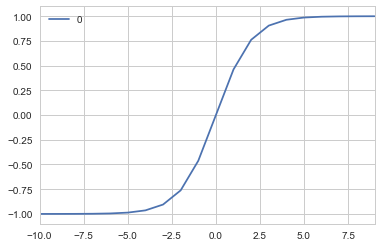

In [102]:
df = pd.DataFrame(F.sigmoid(np.arange(-10,10).astype(np.float32)).data * 2.0 - 1.0,
                  index=np.arange(-10,10))
df.plot()

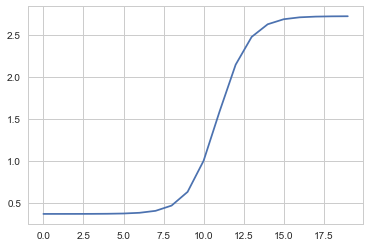

In [103]:
plt.plot(np.exp(F.sigmoid(np.arange(-10,10).astype(np.float32)).data * 2.0 - 1.0))

In [104]:
model2 = YoloDetector()

model_file = os.path.join('..', 'cmd', 'yolo', 'detector', 'detector_iter01000.model')
if os.path.exists(model_file):
    print('load model: %s' % model_file)
    chainer.serializers.load_npz(model_file, model2)

load model: ../cmd/yolo/detector/detector_iter01000.model


In [105]:
h2 = model.forward(xs)

In [124]:
px, py, pw, ph, pconf, pprob = F.split_axis(h2, indices_or_sections=(1,2,3,4,5), axis=2)
#px = F.sigmoid(px)
#py = F.sigmoid(py)
#pconf = F.sigmoid(pconf)
#pprob = F.sigmoid(pprob)

px.shape, py.shape, pw.shape, ph.shape, pconf.shape, pprob.shape

((10, 155, 1, 7),
 (10, 155, 1, 7),
 (10, 155, 1, 7),
 (10, 155, 1, 7),
 (10, 155, 1, 7),
 (10, 155, 2, 7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a8a88550>]], dtype=object)

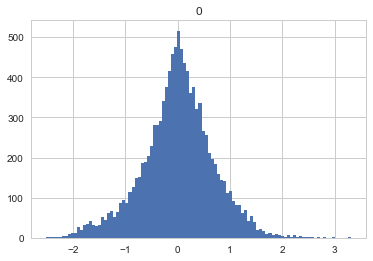

In [125]:
pd.DataFrame(px.data.ravel()).hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x19956f510>]], dtype=object)

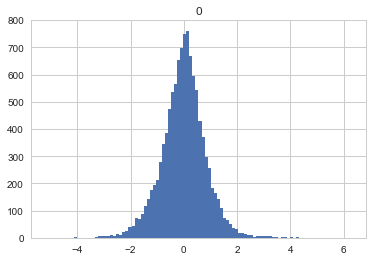

In [126]:
pd.DataFrame(pw.data.ravel()).hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a8b27990>]], dtype=object)

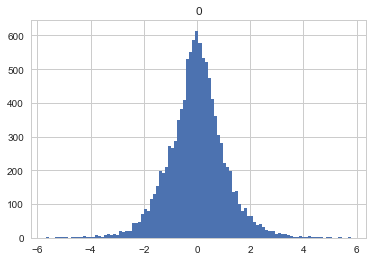

In [127]:
pd.DataFrame(pconf.data.ravel()).hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129024190>]], dtype=object)

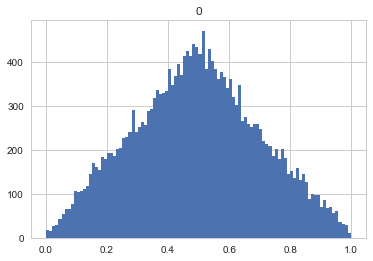

In [119]:
pd.DataFrame(pprob.data.ravel()).hist(bins=100)

## 教師データを作成

In [ ]:
tx = np.tile(0.5, px.shape) # 基本はグリッド中心
ty = np.tile(0.5, py.shape)
tw = np.zeros(ph.shape) # e^t,e^h = 1となるよう基本は0
th = np.zeros(ph.shape)
tconf = np.zeros(pconf.shape) # 基本は0
tprob = pprob.data.copy() # 真のグリッド以外は誤差が発生ないよう推定値をコピー

In [ ]:
x_offsets = np.broadcast_to(np.arange(N_GRID).astype(np.float32), px.shape[1:])
y_offsets = np.broadcast_to(np.arange(N_GRID).astype(np.float32), py.shape[1:])
w_anchors = np.broadcast_to(np.reshape(np.array(ANCHOR_BOXES).astype(np.float32)[:, 0], (N_BOXES, 1, 1, 1)), pw.shape[1:])
h_anchors = np.broadcast_to(np.reshape(np.array(ANCHOR_BOXES).astype(np.float32)[:, 0], (N_BOXES, 1, 1, 1)), ph.shape[1:])

In [ ]:
def all_pred_boxes(px, py, pw, ph):
    x_offsets = np.broadcast_to(np.arange(N_GRID).astype(np.float32), px.shape)
    y_offsets = np.broadcast_to(np.arange(N_GRID).astype(np.float32), py.shape)
    w_anchors = np.broadcast_to(np.reshape(np.array(ANCHOR_BOXES).astype(np.float32)[:,0], (N_BOXES,1,1,1)), pw.shape)
    h_anchors = np.broadcast_to(np.reshape(np.array(ANCHOR_BOXES).astype(np.float32)[:,0], (N_BOXES,1,1,1)), ph.shape)
    return Box(x=x_offsets + F.sigmoid(px).data, y=y_offsets + F.sigmoid(py).data,
               width=np.exp(pw) * w_anchors, height=np.exp(ph) * h_anchors)

In [ ]:
best_ious = []
for batch in range(0, batch_size):
    ious = []
    pboxes = all_pred_boxes(px.data[batch], py.data[batch], pw.data[batch], ph.data[batch])
    for truth_box in ground_truths[batch]:
        tboxes = Box(
            x=np.broadcast_to(np.array(truth_box.left).astype(np.float32), pboxes.left.shape),
            y=np.broadcast_to(np.array(truth_box.top).astype(np.float32), pboxes.top.shape),
            width=np.broadcast_to(np.array(truth_box.width).astype(np.float32), pboxes.width.shape),
            height=np.broadcast_to(np.array(truth_box.height).astype(np.float32), pboxes.height.shape)
        )
        ious.append(Box.iou(pboxes, tboxes))

    ious = np.asarray(ious)
    best_ious.append(np.max(ious, axis=0))

best_ious = np.asarray(best_ious).reshape(batch_size, N_BOXES, 1, N_GRID, N_GRID)

In [ ]:
best_ious.shape

In [ ]:
pconf[best_ious > 0.1]

In [ ]:
pconf.data.copy()[best_ious > 0.1]

## 推論の結果を評価

In [ ]:
h.shape

In [ ]:
tensor = h[0]
tensor.shape

In [ ]:
tensor[0].shape

In [ ]:
px, py, pw, ph, pconf, pprob = np.array_split(tensor[0], indices_or_sections=(1,2,3,4,5), axis=0)
pconf = F.sigmoid(pconf).data

px.shape, py.shape, pw.shape, ph.shape, pconf.shape, pprob.shape

In [ ]:
# グリッド毎のクラス確率を算出 (N_BOXES, N_CLASSES, N_GRID, N_GRID)
class_prob_map = pprob * pconf

# 最大クラス確率となるクラスラベルを抽出 (N_BOXES, N_GRID, N_GRID)
class_label_map = class_prob_map.argmax(axis=0)

# 最大クラス確率が閾値以上のグリッドを検出候補として抽出 (N_BOXES, N_GRID, N_GRID)
candidate_map = class_prob_map.max(axis=0) > CLASS_PROBABILITY_THRESH

# 検出候補のグリッド位置を抽出 (N_BOXES, )
grid_cells = [Point(x=float(point[1]), y=float(point[0])) for point in np.argwhere(candidate_map)]

In [ ]:
px[0][candidate_map][0]

In [ ]:
candidates = []
for i in six.moves.range(0, candidate_map.sum()):
    w = np.exp(pw[candidate_map][i]) * anchor_box[0]
    h = np.epx(ph[candidate_map][i]) * anchor_box[1]
    x = max(px[candidate_map][i] + grid_cell.x - w/2, 0.)
    y = max(py[candidate_map][i] + grid_cell.y - h/2, 0.)
    w = min(w, N_GRID - x)
    h = min(h, N_GRID - y)
    grid_box = Box(x=x, y=y, width=w, height=h,
                           confidence=pconf[candidate_map][i],
                           clazz=class_label_map[candidate_map][i],
                           objectness=class_prob_map.max(axis=0)[candidate_map][i])
    candidates.append(grid_to_yolo_coord(grid_box, grid_cells[i]))

In [ ]:
pconf[0][candidate_map]

In [ ]:
plt.plot(F.tanh(np.arange(-100,100,2).astype(np.float32) / 100.).data)

In [ ]:
np.exp(0)

In [ ]:
F.tanh(np.arange(-100,100,2)).data

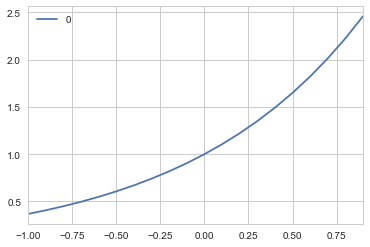

In [154]:
pd.DataFrame(np.exp(np.arange(-1,1,0.1)), index=np.arange(-1,1,0.1)).plot()

In [ ]:
np.random.randint(0, 255, size=(1,3,224,224)) / 255.

In [188]:
ANCHOR_BOXES = np.array([[5.375, 5.03125], [5.40625, 2.6875], [2.96875, 2.53125], [1.59375, 1.78125], [1.2375, 5.25]])
int(len(ANCHOR_BOXES))

5

In [189]:
np.sort(np.asarray([0.09165094, 0.15258172, 0.69590072, 0.17525685, 0.78319937, 0.64341082,
      0.59390963, 0.61937724, 0.61221406, 0.19246834, 0.63833827, 0.,
      0.07429834, 0.68174421, 0.301886, 0.36671587, 0.70641377, 0.17396223,
      0.19986209, 0.57469907]))[::-1]

array([ 0.78319937,  0.70641377,  0.69590072,  0.68174421,  0.64341082,
        0.63833827,  0.61937724,  0.61221406,  0.59390963,  0.57469907,
        0.36671587,  0.301886  ,  0.19986209,  0.19246834,  0.17525685,
        0.17396223,  0.15258172,  0.09165094,  0.07429834,  0.        ])

In [190]:
truth_box = ts[0][0]
truth_box

<Box x:3.0625 y:1.96875 w:3.0953125 h:4.52083333333 c:17 o:1.0>

In [193]:
anchor_ious = np.asarray([Box.iou(Box(0., 0., anchor_box[0], anchor_box[1]),
                            Box(0., 0., truth_box.width, truth_box.height))
                    for anchor_box in ANCHOR_BOXES])

In [196]:
anchor_ious

array([ 0.51745029,  0.4117322 ,  0.53701408,  0.20287198,  0.37557939])

In [195]:
np.argmax(anchor_ious)

2